In [442]:
import sys
import os
import platform
import importlib
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
elif platform.system() == 'Linux':
    base_FP = '/data'
    cpuserver_data_FP = '/data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')
print(base_FP, cpuserver_data_FP)

#hydroAI libs
import HydroAI.ASCAT_TUW as hASCAT_TUW
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
importlib.reload(hASCAT_TUW)
importlib.reload(hPlot)
importlib.reload(hData)
importlib.reload(hGrid)

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

# Define your directory where to save nc files
nc_save_dir = cpuserver_data_FP + '/extracted_nc'
output_dir  = cpuserver_data_FP + '/ASCAT/TUW/csv'  

/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive /Users/hyunglokkim/cpuserver_data


## 1. Import ASCAT data from raw files

In [137]:
# get the WARP5 Grid Information (GI) nc file
ASCAT_FP = cpuserver_data_FP + '/ASCAT/TUW'
GI_file_path = os.path.join(ASCAT_FP, 'warp5_grid/TUW_WARP5_grid_info_2_3.nc')
# check the variable names and their units
hData.get_nc_variable_names_units(GI_file_path);

gpi = hData.get_variable_from_nc(GI_file_path, 'gpi')
lat = hData.get_variable_from_nc(GI_file_path, 'lat')
lon = hData.get_variable_from_nc(GI_file_path, 'lon')
cell = hData.get_variable_from_nc(GI_file_path, 'cell')

+----------------+------------------------------+---------------+
| Name           | Long Name                    | Units         |
+================+==============================+===============+
| lon            | location longitude           | degrees_east  |
+----------------+------------------------------+---------------+
| lat            | location latitude            | degrees_north |
+----------------+------------------------------+---------------+
| gpi            | grid point index             |               |
+----------------+------------------------------+---------------+
| cell           | cell number                  |               |
+----------------+------------------------------+---------------+
| land_flag      | land flag                    |               |
+----------------+------------------------------+---------------+
| committed_area | Committed soil moisture area |               |
+----------------+------------------------------+---------------+


In [3]:
# ASCAT nc files
nc_file_path = os.path.join(ASCAT_FP, 'h119')
h119 = hData.get_file_list(nc_file_path, 'nc')
nc_file_path = os.path.join(ASCAT_FP, 'h120')
h120 = hData.get_file_list(nc_file_path, 'nc')
ASCAT_file_path = h119+h120
hData.get_nc_variable_names_units(ASCAT_file_path[0]);
nof = len(ASCAT_file_path)

+----------------------+-----------------------------------------+--------------------------------+
| Name                 | Long Name                               | Units                          |
+======================+=========================================+================================+
| row_size             | number of observations at this location |                                |
+----------------------+-----------------------------------------+--------------------------------+
| lon                  | location longitude                      | degrees_east                   |
+----------------------+-----------------------------------------+--------------------------------+
| lat                  | location latitude                       | degrees_north                  |
+----------------------+-----------------------------------------+--------------------------------+
| alt                  | vertical distance above the surface     | m                              |


In [4]:
unique_cell_numbers = []
index_map = {}

for index, path in enumerate(ASCAT_file_path):
    identifier = path.split('_')[-1].split('.')[0]
    if identifier not in unique_cell_numbers:
        unique_cell_numbers.append(identifier)
        index_map[identifier] = [index]
    else:
        index_map[identifier].append(index)

In [5]:
# Function to convert fraction of days since 1900-01-01 00:00:00 UTC to local time
def convert_to_local_time(df):
    # Calculate UTC time
    base_date = datetime(1900, 1, 1, 0, 0, 0)
    utc_time = base_date + pd.to_timedelta(df['time'], unit='D')

    # Calculate timezone offset based on longitude
    timezone_offset_hours = df['lon'] / 15  # 15 degrees per hour
    timezone_offset = pd.to_timedelta(timezone_offset_hours, unit='H')

    # Convert to local time
    local_time = utc_time + timezone_offset

    # Convert local time back to fraction of days since 1900-01-01 00:00:00
    local_time_fraction_days = (local_time - base_date) / timedelta(days=1)

    return local_time_fraction_days

## 1-1. Creat core csv files (should be updated yearly basis -- last updated Jun 1 2024)

In [6]:
# Single file operator
geo_vars = ['row_size', 'lon', 'lat', 'location_id']
obs_vars = ['time', 'sm', 'sm_noise', 'ssf', 'dir', 'proc_flag', 'corr_flag', 'conf_flag','sigma40', 'sigma40_noise']

# Extract geolocation related data for a specific k
for k in [2]:#range(unique_cell_numbers):

    h_file_index = index_map.get(unique_cell_numbers[k], [])
    
    obs_df_list = []
    for kk in h_file_index:
        t_ASCAT_file_name = ASCAT_file_path[kk]
        t_cell_number = t_ASCAT_file_name[-7:-3] # cell #
        #t_h_number = t_ASCAT_file_name[-11:-8]   # H119 or H120
    
        print(t_ASCAT_file_name)
        # Extract geolocation related data
        geo_df = pd.DataFrame(columns=geo_vars).drop(columns='row_size')
        t_row_size = hData.get_variable_from_nc(t_ASCAT_file_name, 'row_size')
        t_lon = hData.get_variable_from_nc(t_ASCAT_file_name, 'lon')
        t_lat = hData.get_variable_from_nc(t_ASCAT_file_name, 'lat')
        t_location_id = hData.get_variable_from_nc(t_ASCAT_file_name, 'location_id')
        
        # Extract observation related data
        t_time = hData.get_variable_from_nc(t_ASCAT_file_name, 'time')
        t_sm = hData.get_variable_from_nc(t_ASCAT_file_name, 'sm')
        t_sm_noise = hData.get_variable_from_nc(t_ASCAT_file_name, 'sm_noise')
        t_ssf = hData.get_variable_from_nc(t_ASCAT_file_name, 'ssf')
        t_dir = hData.get_variable_from_nc(t_ASCAT_file_name, 'dir')
        t_proc_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'proc_flag')
        t_corr_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'corr_flag')
        t_conf_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'conf_flag')
        t_sigma40 = hData.get_variable_from_nc(t_ASCAT_file_name, 'sigma40')
        t_sigma40_noise = hData.get_variable_from_nc(t_ASCAT_file_name, 'sigma40_noise')
        
        t_dir = t_dir.astype(float)  # Convert orbit_dir to float
        t_row_size = t_row_size[~np.isnan(t_row_size)]
        obs_partial_df = pd.DataFrame(index=np.arange(t_row_size.sum()), columns=obs_vars+['lon', 'lat', 'location_id'])
        
        # Save them to dataframes
        row_start = np.zeros(len(t_row_size), dtype=int)
        row_end = np.zeros(len(t_row_size), dtype=int)
    
        for i in range(len(t_row_size)):
    
            geo_df.loc[i, 'lon'] = t_lon[i]
            geo_df.loc[i, 'lat'] = t_lat[i]
            geo_df.loc[i, 'location_id'] = t_location_id[i]
                
            if i == 0:
                row_start[0] = 0
                row_end[0] = t_row_size[0]
            else:
                row_start[i] = row_end[i-1]
                row_end[i] = row_start[i] + t_row_size[i]
        
            for var in obs_vars:
                obs_partial_df.loc[row_start[i]:row_end[i]-1, var] = globals()[f't_{var}'][row_start[i]:row_end[i]]
    
            obs_partial_df.loc[row_start[i]:row_end[i]-1, 'lon'] = geo_df.loc[i, 'lon']
            obs_partial_df.loc[row_start[i]:row_end[i]-1, 'lat'] = geo_df.loc[i, 'lat']
            obs_partial_df.loc[row_start[i]:row_end[i]-1, 'location_id'] = geo_df.loc[i, 'location_id']
             
        # Append the partial DataFrame to the list
        obs_df_list.append(obs_partial_df)
    
    # Concatenate all partial DataFrames into a single DataFrame
    obs_df = pd.concat(obs_df_list, ignore_index=True)
    obs_df['local_time'] = convert_to_local_time(obs_df)
    obs_df.to_csv(os.path.join(output_dir, 'h119_h120_'+t_cell_number+'.csv'))

/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h119/H119_0032.nc
/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h120/H120_0032.nc


In [15]:
# Parallelize the execution of the loop using joblib
# Function to process data for a specific range of k values
def process_data(k_range, unique_cell_numbers):
    for k in k_range:
        h_file_index = index_map.get(unique_cell_numbers[k], [])

        obs_df_list = []
        for kk in h_file_index:
            t_ASCAT_file_name = ASCAT_file_path[kk]
            t_cell_number = t_ASCAT_file_name[-7:-3]  # cell #
            #t_h_number = t_ASCAT_file_name[-11:-8]   # H119 or H120

            print(t_ASCAT_file_name)
            # Extract geolocation related data
            geo_df = pd.DataFrame(columns=geo_vars).drop(columns='row_size')
            
            t_row_size = hData.get_variable_from_nc(t_ASCAT_file_name, 'row_size')
            t_lon = hData.get_variable_from_nc(t_ASCAT_file_name, 'lon')
            t_lat = hData.get_variable_from_nc(t_ASCAT_file_name, 'lat')
            t_location_id = hData.get_variable_from_nc(t_ASCAT_file_name, 'location_id')
            
            # Extract observation related data
            for var in obs_vars:
                globals()[f't_{var}'] = hData.get_variable_from_nc(t_ASCAT_file_name, var)
                
            t_time = hData.get_variable_from_nc(t_ASCAT_file_name, 'time')
            t_sm = hData.get_variable_from_nc(t_ASCAT_file_name, 'sm')
            t_sm_noise = hData.get_variable_from_nc(t_ASCAT_file_name, 'sm_noise')
            t_ssf = hData.get_variable_from_nc(t_ASCAT_file_name, 'ssf')
            t_dir = hData.get_variable_from_nc(t_ASCAT_file_name, 'dir')
            t_proc_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'proc_flag')
            t_corr_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'corr_flag')
            t_conf_flag = hData.get_variable_from_nc(t_ASCAT_file_name, 'conf_flag')
            t_sigma40 = hData.get_variable_from_nc(t_ASCAT_file_name, 'sigma40')
            t_sigma40_noise = hData.get_variable_from_nc(t_ASCAT_file_name, 'sigma40_noise')
            
            t_dir = t_dir.astype(float)  # Convert orbit_dir to float
            t_row_size = t_row_size[~np.isnan(t_row_size)]
            obs_partial_df = pd.DataFrame(index=np.arange(t_row_size.sum()), columns=obs_vars+['lon', 'lat', 'location_id'])

            # Save them to dataframes
            row_start = np.zeros(len(t_row_size), dtype=int)
            row_end = np.zeros(len(t_row_size), dtype=int)

            for i in range(len(t_row_size)):
                geo_df.loc[i, 'lon'] = t_lon[i]
                geo_df.loc[i, 'lat'] = t_lat[i]
                geo_df.loc[i, 'location_id'] = t_location_id[i]

                if i == 0:
                    row_start[0] = 0
                    row_end[0] = t_row_size[0]
                else:
                    row_start[i] = row_end[i-1]
                    row_end[i] = row_start[i] + t_row_size[i]

                for var in obs_vars:
                    obs_partial_df.loc[row_start[i]:row_end[i]-1, var] = globals()[f't_{var}'][row_start[i]:row_end[i]]

                obs_partial_df.loc[row_start[i]:row_end[i]-1, 'lon'] = geo_df.loc[i, 'lon']
                obs_partial_df.loc[row_start[i]:row_end[i]-1, 'lat'] = geo_df.loc[i, 'lat']
                obs_partial_df.loc[row_start[i]:row_end[i]-1, 'location_id'] = geo_df.loc[i, 'location_id']

            # Append the partial DataFrame to the list
            obs_df_list.append(obs_partial_df)

        # Concatenate all partial DataFrames into a single DataFrame
        obs_df = pd.concat(obs_df_list, ignore_index=True)
        obs_df['local_time'] = convert_to_local_time(obs_df)
        #obs_df.to_csv(os.path.join(output_dir, 't_h119_h120_' + t_cell_number + '.csv'))
        obs_df.to_csv(os.path.join(output_dir, 'h119_h120_' + t_cell_number + '.csv'))

# Number of processors to use
n_processors = 48

# Divide the range into chunks based on the number of processors
chunk_size = len(unique_cell_numbers) // n_processors
ranges = [range(i * chunk_size, (i + 1) * chunk_size) for i in range(n_processors)]

# If there are remaining elements, add them to the last chunk
if len(unique_cell_numbers) % n_processors != 0:
    ranges[-1] = range((n_processors - 1) * chunk_size, len(unique_cell_numbers))

# Run the processing in parallel
Parallel(n_jobs=n_processors)(delayed(process_data)(k_range, unique_cell_numbers) for k_range in ranges)

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_17429/180234113.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_17429/180234113.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_17429/180234113.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_17429/180234113.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_17429/180234113.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_17429/18023

/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h119/H119_0030.nc
/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h120/H120_0030.nc
/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h119/H119_0031.nc
/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h120/H120_0031.nc
/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h119/H119_1523.nc
/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h120/H120_1523.nc
/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h119/H119_1524.nc
/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/h120/H120_1524.nc


KeyboardInterrupt: 

In [373]:
def create_3d_object_array(x, y, z):
    """
    Create a 3D NumPy array that can store list data, with the specified shape (x, y, z).
    
    Parameters:
    x (int): Size of the first dimension.
    y (int): Size of the second dimension.
    z (int): Size of the third dimension.
    
    Returns:
    np.ndarray: 3D NumPy array of shape (x, y, z) with dtype=object.
    """
    # Create an empty array with the given shape and dtype=object
    obj_array = np.empty((x, y, z), dtype=object)
    
    # Initialize each element to an empty list
    for i in range(x):
        for j in range(y):
            for k in range(z):
                obj_array[i, j, k] = []
    
    return obj_array

In [374]:
target_lon, target_lat = hGrid.generate_lon_lat_eqdgrid(0.25)
start_year = 2007
end_year   = 2023
num_days   = (datetime(end_year+1,1,1) - datetime(start_year,1,1)).days
cutoff_datetime = pd.to_datetime(str(end_year+1)+'-01-01 00:00:00')

csv_folder = os.path.join(ASCAT_FP, 'csv')
csv_file_path = hData.get_file_list(csv_folder, 'csv')

In [309]:
i = 1 

orbit = 0 # 0: ascending (pm; 21:30) / 1: descending (am; 9:30)

t_csv_file_name = csv_file_path[i]
print(t_csv_file_name)
t_cell_number   = t_csv_file_name[-8:-4]
t_lat           = pd.read_csv(t_csv_file_name, usecols=['lat'])
t_lon           = pd.read_csv(t_csv_file_name, usecols=['lon'])
t_local_time    = pd.read_csv(t_csv_file_name, usecols=['local_time'])
t_time          = pd.read_csv(t_csv_file_name, usecols=['time'])
t_location_id   = pd.read_csv(t_csv_file_name, usecols=['location_id'])
t_sm            = pd.read_csv(t_csv_file_name, usecols=['sm'])
t_conf_flag     = pd.read_csv(t_csv_file_name, usecols=['conf_flag'])
t_dir           = pd.read_csv(t_csv_file_name, usecols=['dir'])

/Users/hyunglokkim/cpuserver_data/ASCAT/TUW/csv/h119_h120_0031.csv


In [313]:
# Convert fractional days to datetime
base_date = datetime(1900, 1, 1)
t_local_time['datetime'] = t_local_time['local_time'].apply(lambda x: base_date + timedelta(days=x))

# Define the base year for DOY calculation
base_year = start_year

# Function to calculate DOY with baseline year
def calculate_doy(dt, base_year):
    year_start = datetime(base_year, 1, 1)
    doy = (dt - year_start).days + 1
    return doy

# Apply the function to calculate DOY
t_local_time['doy'] = t_local_time['datetime'].apply(lambda x: calculate_doy(x, base_year))

           local_time                   datetime   doy
0        39085.417395 2007-01-05 10:01:02.922379     5
1        39085.486970 2007-01-05 11:41:14.172373     5
2        39086.402920 2007-01-06 09:40:12.296372     6
3        39086.816049 2007-01-06 19:35:06.672348     6
4        39086.885733 2007-01-06 21:15:27.297345     6
...               ...                        ...   ...
8016948  45291.890410 2024-01-02 21:22:11.461385  6211
8016949  45292.423961 2024-01-03 10:10:30.212389  6212
8016950  45292.493579 2024-01-03 11:50:45.212392  6212
8016951  45292.768861 2024-01-03 18:27:09.587389  6212
8016952  45293.409529 2024-01-04 09:49:43.337398  6213

[8016953 rows x 3 columns]


In [457]:
t_ll_idx = hData.find_closest_index(target_lon, target_lat, [np.min(t_lon), np.min(t_lat)])
t_lr_idx = hData.find_closest_index(target_lon, target_lat, [np.max(t_lon), np.min(t_lat)])
t_ul_idx = hData.find_closest_index(target_lon, target_lat, [np.min(t_lon), np.max(t_lat)])
t_ur_idx = hData.find_closest_index(target_lon, target_lat, [np.max(t_lon), np.max(t_lat)])

t_target_frame = create_3d_object_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1) #+1 because python starts from 0
t_final_target_frame = np.full((t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1), np.nan)

t_target_frame_QC = create_3d_object_array(t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1) #+1 because python starts from 0
t_final_target_frame_QC = np.full((t_ll_idx[0]-t_ul_idx[0]+1, t_lr_idx[1]-t_ll_idx[1]+1, num_days+1), np.nan)

t_target_lon   = target_lon[t_ul_idx[0]:t_ll_idx[0]+1, t_ll_idx[1]:t_lr_idx[1]+1]
t_target_lat   = target_lat[t_ul_idx[0]:t_ll_idx[0]+1, t_ll_idx[1]:t_lr_idx[1]+1]

In [438]:
t_unique_location_id = pd.DataFrame(np.unique(t_location_id['location_id']).astype('int'), columns=['unique_location_id'])
for ti in range(len(t_unique_location_id)):
    t_lat_idx = hData.find_closest_index(t_target_lon, t_target_lat, [lon[t_unique_location_id.unique_location_id[ti]], lat[t_unique_location_id.unique_location_id[ti]]])[0]
    t_lon_idx = hData.find_closest_index(t_target_lon, t_target_lat, [lon[t_unique_location_id.unique_location_id[ti]], lat[t_unique_location_id.unique_location_id[ti]]])[1]
    t_unique_location_id.loc[ti, 'lat_idx'] = t_lat_idx
    t_unique_location_id.loc[ti, 'lon_idx'] = t_lon_idx

In [439]:
t_data_filter    = (t_local_time['datetime'] < cutoff_datetime) & (t_dir['dir'] == orbit)
t_data_filter_QC = t_data_filter & (t_conf_flag != 0) 

tt_sm = t_sm.loc[t_data_filter].reset_index(drop=True)
tt_local_time = t_local_time[t_data_filter].reset_index(drop=True)
tt_location_id = t_location_id[t_data_filter].reset_index(drop=True)

tt_sm_QC = t_sm.loc[t_data_filter_QC].reset_index(drop=True)
tt_local_time_QC = t_local_time[t_data_filter_QC].reset_index(drop=True)
tt_location_id_QC = t_location_id[t_data_filter_QC].reset_index(drop=True)

for si in tqdm(range(len(tt_sm))):
    tt_lat_idx = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id.iloc[si][0]].lat_idx.iloc[0].astype('int')
    tt_lon_idx = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id.iloc[si][0]].lon_idx.iloc[0].astype('int')
    tt_doy     = tt_local_time.iloc[si]['doy']
    t_target_frame[tt_lat_idx, tt_lon_idx, tt_doy].append(tt_sm.iloc[si]['sm'])
    
for si in tqdm(range(len(tt_sm_QC))):
    tt_lat_idx = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id.iloc[si][0]].lat_idx.iloc[0].astype('int')
    tt_lon_idx = t_unique_location_id[t_unique_location_id['unique_location_id'] == tt_location_id.iloc[si][0]].lon_idx.iloc[0].astype('int')
    tt_doy     = tt_local_time.iloc[si]['doy']
    t_target_frame[tt_lat_idx, tt_lon_idx, tt_doy].append(tt_sm.iloc[si]['sm'])

100%|███████████████████████████████| 4036608/4036608 [16:18<00:00, 4124.22it/s]


In [440]:
for ii in range(t_target_frame.shape[0]):
    for jj in range(t_target_frame.shape[1]):
        for kk in range(t_target_frame.shape[2]):
            t_final_target_frame[ii,jj,kk] = np.nanmean(t_target_frame[ii,jj,kk])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


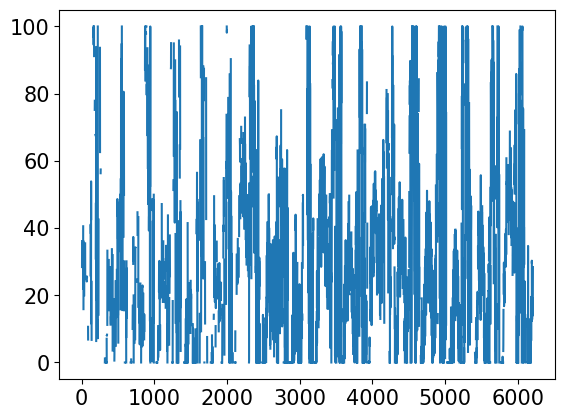

In [448]:
plt.plot(t_final_target_frame[1,6,:])

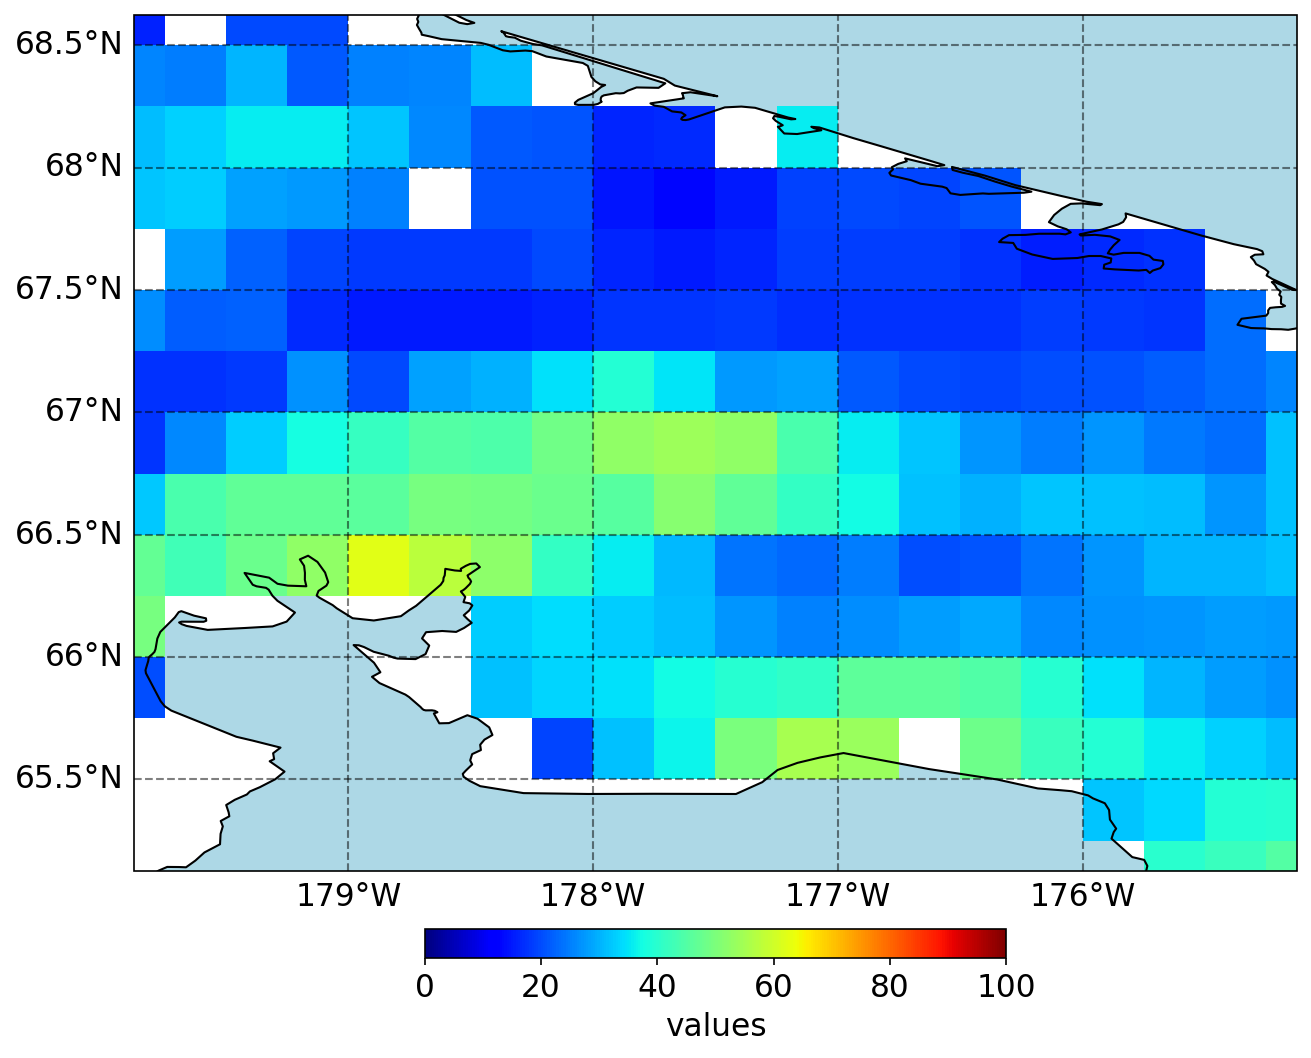

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [443]:
ttt = np.nanmean(t_final_target_frame, axis=2)
hPlot.plot_map(t_target_lon, t_target_lat, ttt, 0, 100, projection='PlateCarree')